# CSE 541 HW1

## Problem 3

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [165]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'BIL', 'BND', 'GLD']
data = yf.download(tickers, period='1y', actions=True)

[*********************100%***********************]  9 of 9 completed


In [166]:
returns = (data['Close'] + data['Dividends']) / data['Close'].shift(1)
returns["Uniformly rebalancing portfolio"] = returns.mean(1)
returns.head()

/var/folders/sd/v_dt5vp17z75wd22155dfr880000gn/T/ipykernel_30344/2916033549.py:2: Pandas4Warning: Starting with pandas version 4.0 all arguments of mean will be keyword-only.
  returns["Uniformly rebalancing portfolio"] = returns.mean(1)


Ticker,AAPL,AMZN,BIL,BND,GLD,GOOG,META,MSFT,NVDA,Uniformly rebalancing portfolio
Date,,,,,,,,,,
2025-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-24,0.996065,0.997579,1.000436,1.001947,1.006219,1.011624,1.017346,0.994068,0.968754,0.999338
2025-01-27,1.031780,1.002427,1.000109,1.005275,0.989595,0.959733,1.019135,0.978607,0.830318,0.979664
2025-01-28,1.036544,1.011596,1.000000,0.999448,1.008656,1.017030,1.021898,1.029087,1.089259,1.023724
2025-01-29,1.004617,0.995465,1.000109,0.999447,0.996160,1.000558,1.003203,0.989110,0.958989,0.994184


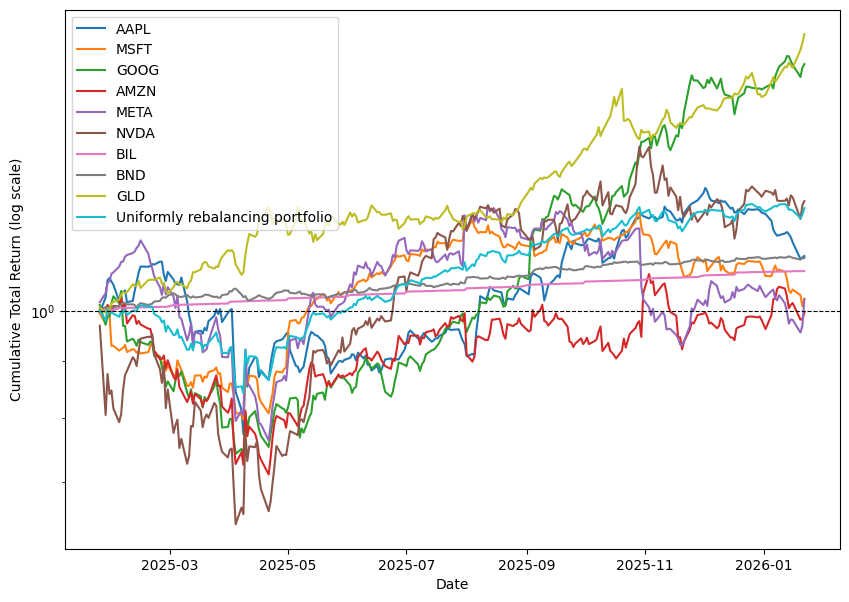

In [167]:
cum_returns = returns.cumprod()
plt.figure(figsize=(10,7))
for ticker in tickers + ['Uniformly rebalancing portfolio']:
    plt.plot(cum_returns.index, cum_returns[ticker], label=ticker)
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Cumulative Total Return (log scale)')
plt.axhline(y=1, color='black', linestyle='--', linewidth=0.8)
plt.legend(loc="upper left")
plt.show()

In [168]:
etas = [0.1, 0.5, 1, 2, 5]
for eta in etas:
    weights = np.ones(len(tickers)) / len(tickers)
    name = f"Portfolio ({eta})"
    for t in range(2, len(returns)):
        weights = weights * np.exp(eta * np.log(returns[tickers].iloc[t-1].values))
        weights = weights / np.sum(weights)
        returns.at[returns.index[t], name] = np.dot(weights, returns[tickers].iloc[t].values)
    

In [169]:
cum_returns = returns.cumprod()
best_expert = cum_returns.iloc[-1].max()
portfolios = cum_returns.iloc[-1, 10:]

Text(0, 0.5, 'Regret')

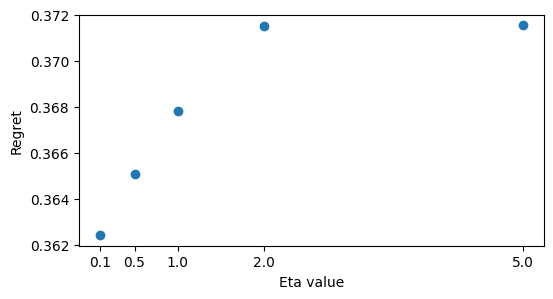

In [170]:
plt.figure(figsize=(6, 3))
plt.scatter(etas, np.log(best_expert) - np.log(portfolios))
plt.xticks(etas)
plt.xlabel("Eta value")
plt.ylabel("Regret")

In [171]:
# randomly sample weights from the probability simplex
weights = np.asarray([
    np.random.exponential(scale=1.0, size = len(tickers))
    for _ in range(1000)
])
weights = weights / np.sum(weights, axis=1, keepdims=True)

# random "experts"
expert_returns = returns[tickers].values[1:] @ weights.T

In [172]:
Ns = [10, 50, 200, 1000]
etas = [1, 10, 50, 100, 200]
portfolios = np.zeros((len(Ns), len(etas), expert_returns.shape[0]))

for i, N in enumerate(Ns):
    for j, eta in enumerate(etas):
        weights = np.ones(N) / N
        portfolios[i, j, 0] = np.dot(weights, expert_returns[0, :N])
        for t in range(1, expert_returns.shape[0]):
            weights = weights * np.exp(eta * np.log(expert_returns[t-1, :N]))
            weights = weights / np.sum(weights)
            portfolios[i, j, t] = np.dot(weights, expert_returns[t, :N]) * portfolios[i, j, t-1]

In [173]:
best_expert = np.asarray([
    np.max(expert_returns[:, :N].prod(axis=0))
    for N in Ns
]).reshape(-1, 1)

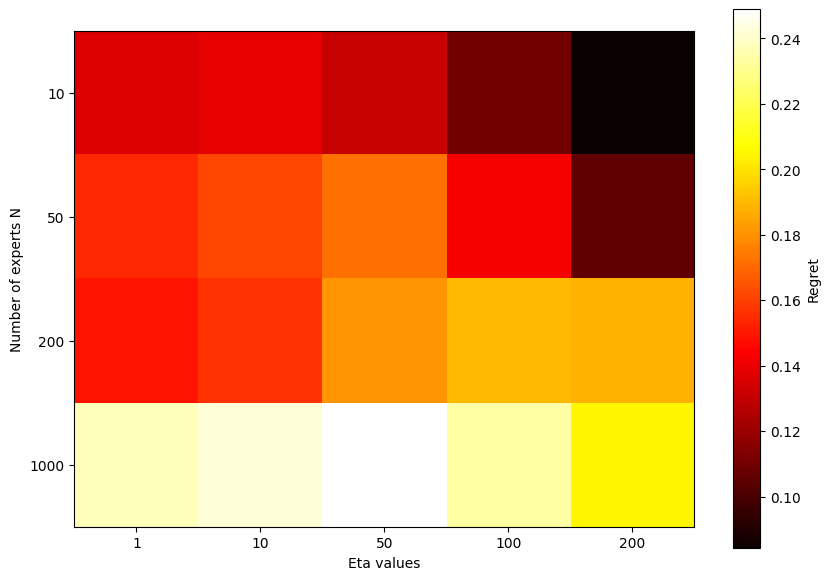

In [146]:
fig, ax = plt.subplots(figsize=(10,7))
im = ax.imshow(np.log(best_expert) - np.log(portfolios[:, :, -1]), cmap="hot")
ax.set_xticks(range(len(etas)))
ax.set_xticklabels(etas)
ax.set_yticks(range(len(Ns)))
ax.set_yticklabels(Ns)
plt.xlabel("Eta values")
plt.ylabel("Number of experts N")
plt.colorbar(im, label="Regret")
plt.show()
plt.show()

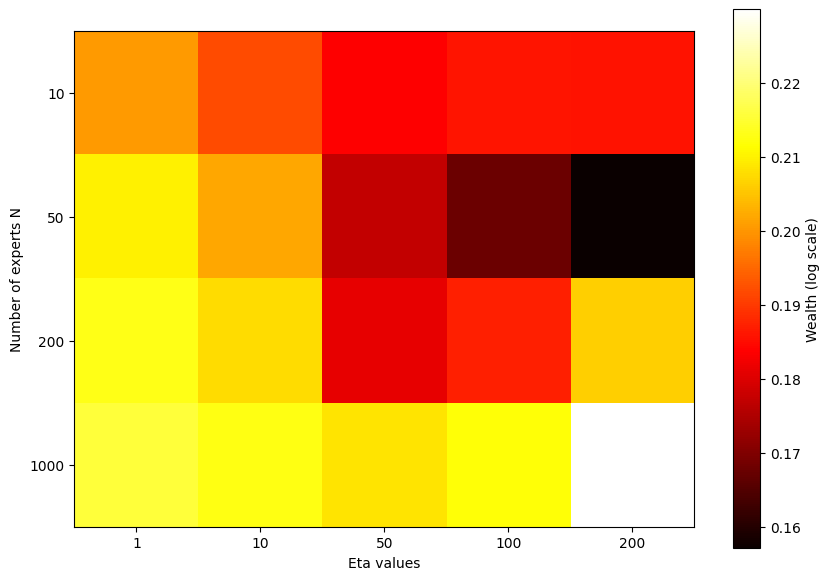

In [183]:
fig, ax = plt.subplots(figsize=(10,7))
im = ax.imshow(np.log(portfolios[:, :, -1]), cmap="hot")
ax.set_xticks(range(len(etas)))
ax.set_xticklabels(etas)
ax.set_yticks(range(len(Ns)))
ax.set_yticklabels(Ns)
plt.xlabel("Eta values")
plt.ylabel("Number of experts N")
plt.colorbar(im, label="Wealth (log scale)")
plt.show()
plt.show()

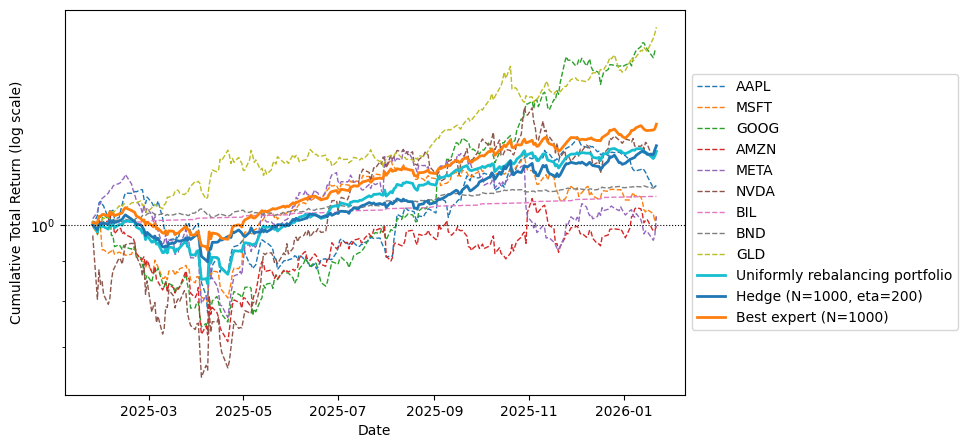

In [184]:
cum_returns = returns.cumprod()
plt.figure(figsize=(8,5))
for ticker in tickers:
    plt.plot(cum_returns.index, cum_returns[ticker], label=ticker, linewidth=1, linestyle = '--')

ticker = 'Uniformly rebalancing portfolio'
plt.plot(cum_returns.index, cum_returns[ticker], label=ticker, linewidth=2, linestyle = '-')

plt.plot(cum_returns.index[1:], portfolios[3, 4], label="Hedge (N=1000, eta=200)", linewidth=2, linestyle = '-')
plt.plot(cum_returns.index[1:], expert_returns.cumprod(axis=0)[:, :10].max(1), label="Best expert (N=1000)", linewidth=2, linestyle = '-')
    
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Cumulative Total Return (log scale)')
plt.axhline(y=1, color='black', linestyle=':', linewidth=0.8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

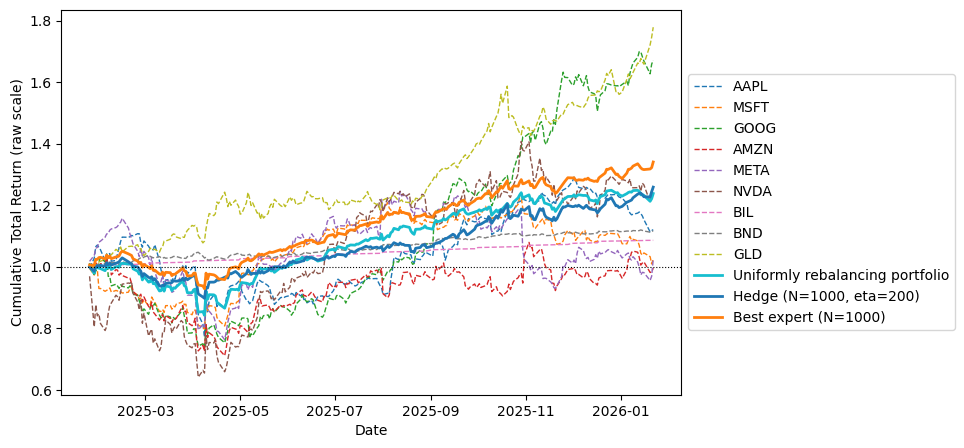

In [185]:
cum_returns = returns.cumprod()
plt.figure(figsize=(8,5))
for ticker in tickers:
    plt.plot(cum_returns.index, cum_returns[ticker], label=ticker, linewidth=1, linestyle = '--')

ticker = 'Uniformly rebalancing portfolio'
plt.plot(cum_returns.index, cum_returns[ticker], label=ticker, linewidth=2, linestyle = '-')

plt.plot(cum_returns.index[1:], portfolios[3, 4], label="Hedge (N=1000, eta=200)", linewidth=2, linestyle = '-')
plt.plot(cum_returns.index[1:], expert_returns.cumprod(axis=0)[:, :10].max(1), label="Best expert (N=1000)", linewidth=2, linestyle = '-')
    
plt.xlabel('Date')
plt.ylabel('Cumulative Total Return (raw scale)')
plt.axhline(y=1, color='black', linestyle=':', linewidth=0.8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Problem 4

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from methods import ucb, thompson_sampling, etc

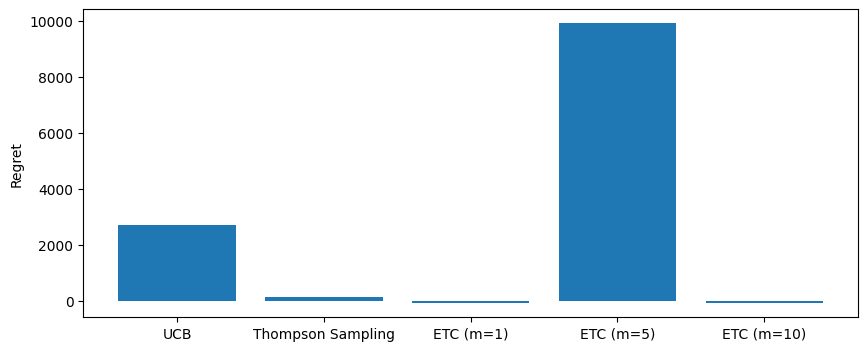

In [77]:
T = 100000
n = 10
np.random.seed(42)
outcomes = np.zeros((n, T))
outcomes[0] = np.random.normal(0.1, 1, size=T)
for i in range(1, n):
    outcomes[i] = np.random.normal(0, 1, size=T)

ucb_returns = ucb(T, outcomes)
ts_returns = thompson_sampling(T, outcomes)
etc_returns_1 = etc(T, outcomes, m=1)
etc_returns_5 = etc(T, outcomes, m=5)
etc_returns_10 = etc(T, outcomes, m=10)

best = 0.1 * T
regrets = best - np.asarray([
    ucb_returns, ts_returns, etc_returns_1, etc_returns_5, etc_returns_10
]).sum(axis=1)
labels = ['UCB', 'Thompson Sampling', 'ETC (m=1)', 'ETC (m=5)', 'ETC (m=10)']

fig, ax = plt.subplots(figsize=(10,4))
plt.bar(labels, regrets)
plt.ylabel("Regret")
plt.show()

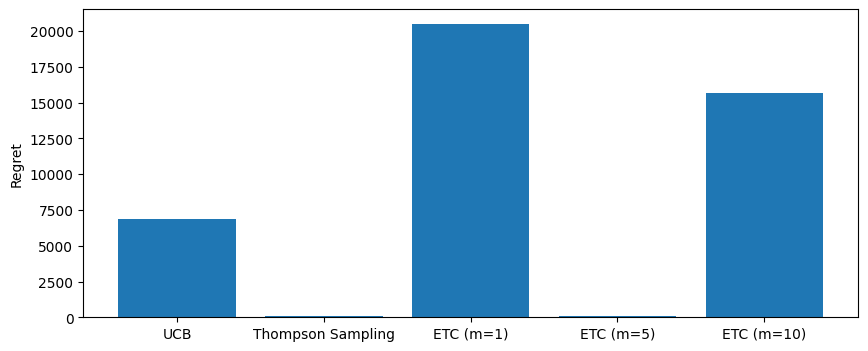

In [79]:
T = 100000
n = 40
np.random.seed(42)
outcomes = np.zeros((n, T))
outcomes[0] = np.random.normal(1, 1, size=T)
for i in range(1, n):
    outcomes[i] = np.random.normal(1 - 1 / np.sqrt(i), 1, size=T)

ucb_returns = ucb(T, outcomes)
ts_returns = thompson_sampling(T, outcomes)
etc_returns_1 = etc(T, outcomes, m=1)
etc_returns_5 = etc(T, outcomes, m=5)
etc_returns_10 = etc(T, outcomes, m=10)

best = 1 * T
regrets = best - np.asarray([
    ucb_returns, ts_returns, etc_returns_1, etc_returns_5, etc_returns_10
]).sum(axis=1)
labels = ['UCB', 'Thompson Sampling', 'ETC (m=1)', 'ETC (m=5)', 'ETC (m=10)']

fig, ax = plt.subplots(figsize=(10,4))
plt.bar(labels, regrets)
plt.ylabel("Regret")
plt.show()